In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import norm
from numpy import linalg as LA
%matplotlib inline

In [489]:
def hmc_sample(U, grad_U, epsilon, L, current_q, std_dev):
    '''
         U: function returns the potential energy given a state q
         grad_u: function returns gradient of U given q
         epsilon: step size
         L: number of Leapfrog steps
         current_q: current generalized state trajectory starts from
         std_dev: vector of standard deviations for Gaussian (hyperparameter)
    '''
    q = current_q
    p = np.random.normal(np.zeros(len(q)), std_dev)  # sample zero-mean Gaussian
    current_p = p

    # Leapfrog: half step for momentum
    p = p - epsilon * grad_U(q) / 2

    for i in range(0, L):
        # Leapfrog: full step for position
        q = q + epsilon * p

        # Leapfrog: combine 2 half-steps for momentum across iterations
        if (i != L-1):
            p = p - epsilon * grad_U(q)

    # Leapfrog: final half step for momentum
    p = p - epsilon * grad_U(q)

    # Negate trajectory to make proposal symmetric (a no-op)
    p = -p

    # Compute potential and kinetic energies
    current_U = U(current_q)
    current_K = np.sum(current_p ** 2) / 2
    proposed_U = U(q)
    proposed_K = np.sum(p ** 2) / 2
    
    # Accept with probability specified using Equation 44:
    if np.random.rand() < np.exp(current_U - proposed_U + current_K - proposed_K):
        return q, 1
    else:
        return current_q, 0

In [455]:
def mh_sampler(f, proposal, steps, initial=0.0):
    x_curr = initial
    while True:
        accept = 0
        for i in range(steps):
            x_next = proposal(_curr)
            if min(1, f(x_next) / f(x_curr)) > np.random.uniform(0, 1):
                x_curr = x_next
                accept += 1
        yield x_curr, accept / steps

# Normal Distribution

In [613]:
def U(x):
    # -log[norm_pdf(x)]
    return 0.5 * np.log(2 * np.pi) + (0.5 * (x ** 2))

def grad_U(x):
    # https://en.wikipedia.org/wiki/Normal_distribution#Symmetries_and_derivatives
    return x

def f(x):
    ''' Only has to be propotional to our pdf '''
    return np.exp(-0.5 * (x ** 2))

def proposal(x):
    return np.random.normal(x, 1.0)
   
f(0), proposal(1.0)

(1.0, 1.0912292960474397)

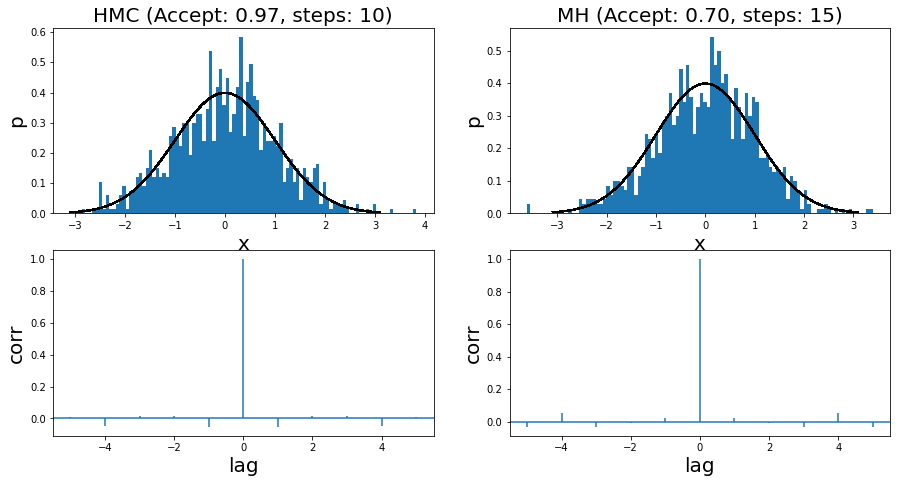

<Figure size 360x360 with 0 Axes>

In [620]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 7.5))

fig = plt.figure(figsize=(5, 5))


# Plot norm PDF
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 1000 )
for i in range(0, len(x), 1):
    ax1.plot(x, norm.pdf(x), color='black', markersize=0)

q = 0
eps = 0.16
steps = 10
N = 1000

samples = []
accepts = 0
for i in range(0, N, 1):
    sample, accept = hmc_sample(U, grad_U, eps, steps, np.array([q]), std_dev=1.0)
    samples.append(sample[0])
    accepts += accept
    q = samples[-1]

ax1.set_title("HMC (Accept: %.2f, steps: %d)" % (accepts / N, steps), fontsize=20)
ax1.set_xlabel("x", fontsize=20)
ax1.set_ylabel("p", fontsize=20)
ax1.hist(samples, bins=100, density=True)

s = pd.Series(samples)
ax3.acorr(samples, maxlags=5)
ax3.set_xlabel("lag", fontsize=20)
ax3.set_ylabel("corr", fontsize=20)

# Plot norm PDF
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 1000 )
for i in range(0, len(x), 1):
    ax2.plot(x, norm.pdf(x), color='black', markersize=0)
    
steps = 15
N = 1000

samples = []
accepts = 0
sampler = mh_sampler(f, proposal, steps)
for i in range(0, N, 1):
    sample, accept = next(sampler)
    samples.append(sample)
    accepts += accept
    q = samples[-1]
 
ax2.set_title("MH (Accept: %.2f, steps: %d)" % (accepts / N, steps), fontsize=20)
ax2.set_xlabel("x", fontsize=20)
ax2.set_ylabel("p", fontsize=20)
ax2.hist(samples, bins=100, density=True)

s = pd.Series(samples)
ax4.acorr(samples, maxlags=5)
ax4.set_xlabel("lag", fontsize=20)
ax4.set_ylabel("corr", fontsize=20)
None

# Bi-Modal Distribution

In [460]:
def U(x):
    # -log[0.5 * norm_pdf(x, 4, 1) + 0.5 * norm_pdf(x, 4, 1)]
    return -np.log(0.25 * norm.pdf(x, -4, 1) + 0.75 * norm.pdf(x, 4, 1))

def grad_U(x):
    # https://en.wikipedia.org/wiki/Normal_distribution#Symmetries_and_derivatives
    return (-1. / U(x)) * (-(x + 4) * 0.25 * norm.pdf(x, -4, 1) - (x - 4) * 0.75 * norm.pdf(x, 4, 1))

def f(x):
    ''' Only has to be propotional to our pdf '''
    return 0.25 * norm.pdf(x, -4, 1) + 0.75 * norm.pdf(x, 4, 1)

def proposal(x, std_dev):
    return np.random.normal(x, std_dev)

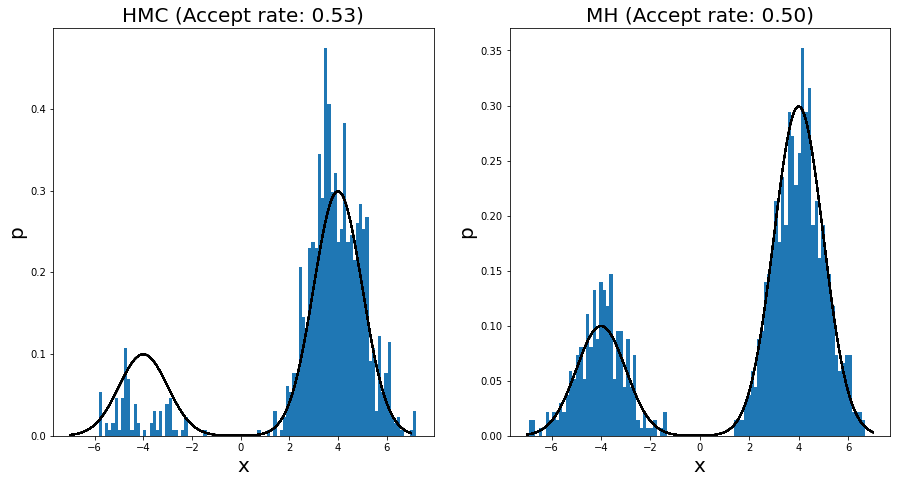

<Figure size 360x360 with 0 Axes>

In [466]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 7.5))

fig = plt.figure(figsize=(5, 5))


# Plot norm PDF
def plot_pdf(ax):
    x = np.linspace(-7, 7, 2000)
    for i in range(0, len(t), 1):
        ax.plot(x, f(x), color='black', markersize=0)

plot_pdf(ax1)
plot_pdf(ax2)
plot_pdf(ax3)
plot_pdf(ax4)

# Plot 1 - HMC
q = 4
eps = 0.05
steps = 20
N = 1000

samples = []
accepts = 0
for i in range(0, N, 1):
    sample, accept = hmc_sample(U, grad_U, eps, steps, np.array([q]), std_dev=2.0)
    samples.append(sample[0])
    accepts += accept
    q = samples[-1]

ax1.set_title("HMC (Accept rate: %.2f)" % (accepts / N), fontsize=20)
ax1.set_xlabel("x", fontsize=20)
ax1.set_ylabel("p", fontsize=20)
ax1.hist(samples, bins=100, density=True)

   
# Plot 2 - MH
steps = 20
N = 1000

samples = []
accepts = 0
sampler = mh_sampler(f, lambda x: proposal(x, std_dev=2.0), steps, 4)
for i in range(0, N, 1):
    sample, accept = next(sampler)
    samples.append(sample)
    accepts += accept
    q = samples[-1]
    
ax2.set_title("MH (Accept rate: %.2f)" % (accepts / N), fontsize=20)
ax2.set_xlabel("x", fontsize=20)
ax2.set_ylabel("p", fontsize=20)
ax2.hist(samples, bins=100, density=True)
None

# Bivariate Normal

In [636]:
binorm_rho = 0.9
binorm_std_dev = (1, 1)
def U(x, std_dev=binorm_std_dev, rho=binorm_rho):
    return (np.log(2 * np.pi * std_dev[0] * std_dev[1] * np.sqrt(1 - rho**2))
            + 1 / (2 * (1 - rho**2)) * (
                (x[0] / std_dev[0])**2 + (x[1] / std_dev[1])**2 
                - 2 * rho * (x[0] / std_dev[0]) * (x[1] / std_dev[1])
           ))

def grad_U(x, std_dev=binorm_std_dev, rho=binorm_rho):
    return (1 / (2 * (1 - rho**2)) * 
            np.array([2 * x[0] / std_dev[0] - 2 * rho / std_dev[0] * x[1] / std_dev[1],
                      2 * x[1] / std_dev[1] - 2 * rho / std_dev[1] * x[0] / std_dev[0]]))

def f(x, std_dev=binorm_std_dev, rho=binorm_rho):
    ''' Only has to be propotional to our pdf '''
    return np.exp(-U(x))

def proposal(x, std_dev):
    return np.random.default_rng().multivariate_normal(mean=[0, 0], cov=np.diag(std_dev))


cov = np.array([[binorm_std_dev[0]**2, 
                 binorm_rho * binorm_std_dev[0] * binorm_std_dev[1]],
                [binorm_rho * binorm_std_dev[0] * binorm_std_dev[1],
                 binorm_std_dev[1]**2]])
eigenvalues, eigenvectors = LA.eig(cov)
  
f([0, 0]), proposal([0, 0], std_dev=[1, 1]), U([0, 0]), grad_U([1, 0]), eigenvalues, eigenvectors

(0.3651264806855467,
 array([ 1.78414857, -0.04519916]),
 1.0075114629985198,
 array([ 5.26315789, -4.73684211]),
 array([1.9, 0.1]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

[1640015774.3139899, 1640015774.6169941, 1640015774.820229, 1640015779.362092]

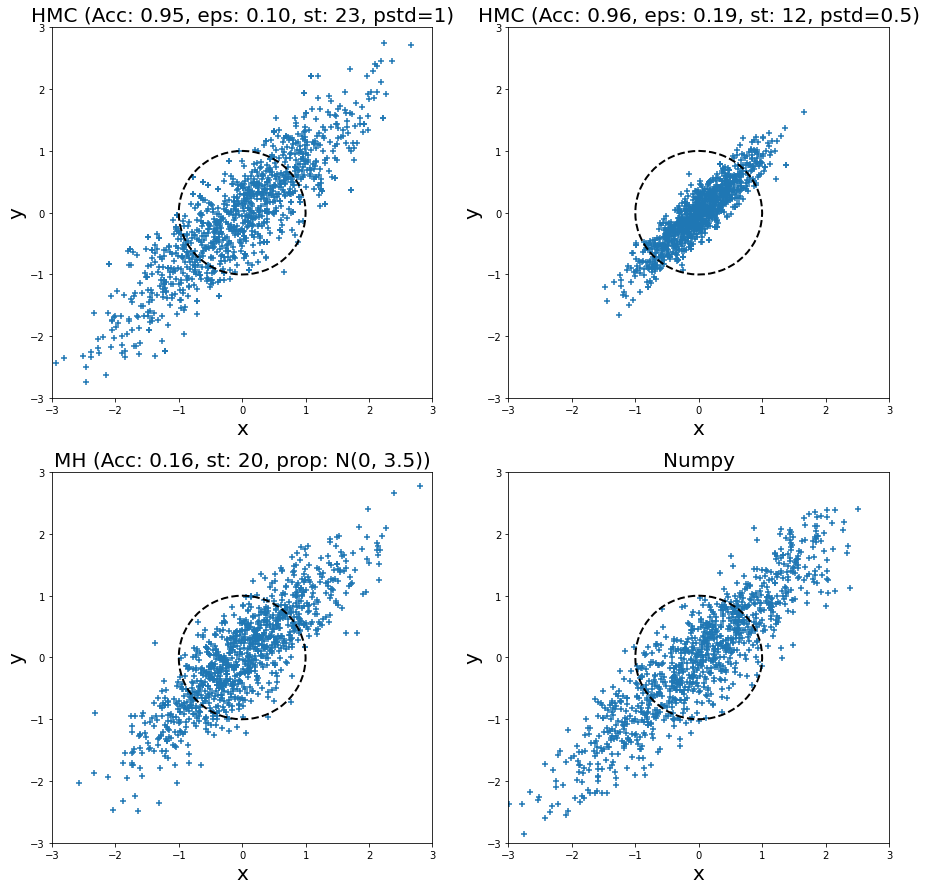

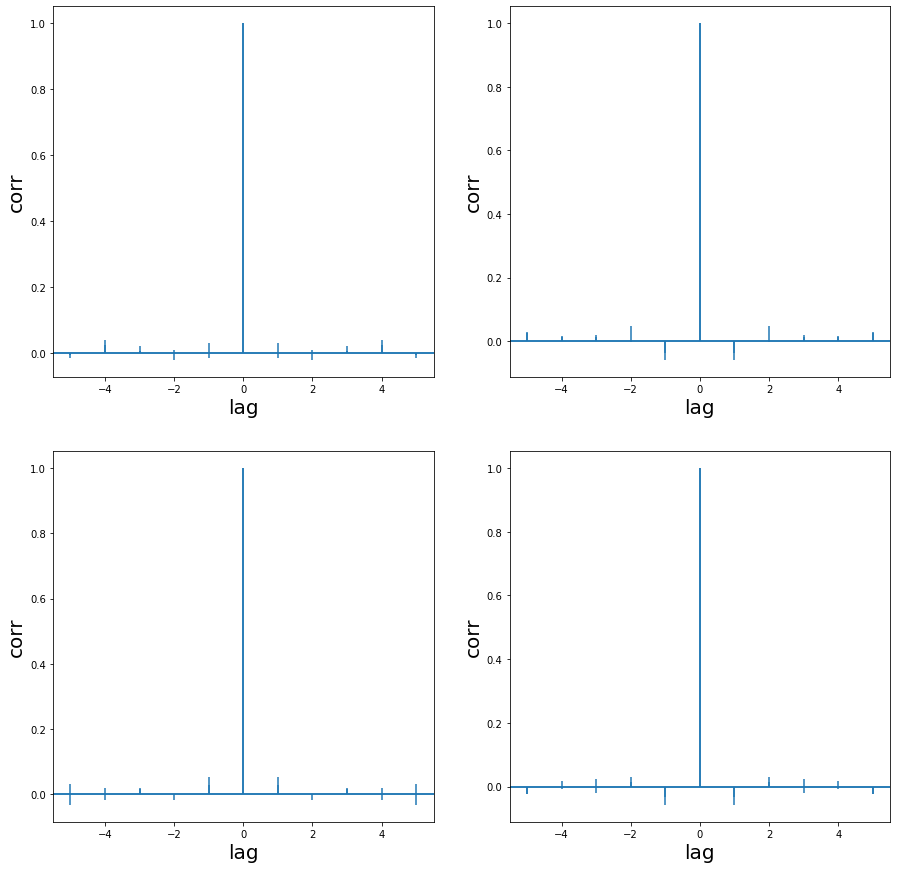

In [678]:
import time

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
fig, ((ac1, ac2), (ac3, ac4)) = plt.subplots(2, 2, figsize=(15, 15))


for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("x", fontsize=20)
    ax.set_xlim([-3, 3])
    ax.set_ylabel("y", fontsize=20)
    ax.set_ylim([-3, 3])
    ellipse = Ellipse(xy=(0, 0), width=2 * binorm_std_dev[0], height=2 * binorm_std_dev[1], 
                      angle=np.rad2deg(np.arctan(v1[1] / v1[0])),
                      edgecolor='black', linestyle='--', fc='None', lw=2)
    ax.add_patch(ellipse)

N = 1000

ts = []
ts.append(time.time())
# HMC
q = [0, 0]
eps = 0.10
steps = 23
std_dev=[1.0, 1.0]

samples = []
accepts = 0
for i in range(0, N, 1):
    sample, accept = hmc_sample(U, grad_U, eps, steps, np.array(q), std_dev=std_dev)
    samples.append(sample)
    accepts += accept
    q = samples[-1]
    
ax1.set_title("HMC (Acc: %.2f, eps: %.2f, st: %d, pstd=1)" % (accepts / N, eps, steps), fontsize=20)
df = pd.DataFrame(samples, columns=['x', 'y'])
ax1.scatter(x=df.x, y=df.y, marker='+')

df = pd.DataFrame(samples, columns=['x', 'y'])
ac1.acorr(df['x'], maxlags=5)
ac1.acorr(df['y'], maxlags=5)
ac1.set_xlabel("lag", fontsize=20)
ac1.set_ylabel("corr", fontsize=20)


ts.append(time.time())
# HMC
q = [0, 0]
eps = 0.19
steps = 12
std_dev=[0.5, 0.5]

samples = []
accepts = 0
for i in range(0, N, 1):
    sample, accept = hmc_sample(U, grad_U, eps, steps, np.array(q), std_dev=std_dev)
    samples.append(sample)
    accepts += accept
    q = samples[-1]
 
ax2.set_title("HMC (Acc: %.2f, eps: %.2f, st: %d, pstd=0.5)" % (accepts / N, eps, steps), fontsize=20)
df = pd.DataFrame(samples, columns=['x', 'y'])
ax2.scatter(x=df.x, y=df.y, marker='+')

df = pd.DataFrame(samples, columns=['x', 'y'])
ac2.acorr(df['x'], maxlags=5)
ac2.acorr(df['y'], maxlags=5)
ac2.set_xlabel("lag", fontsize=20)
ac2.set_ylabel("corr", fontsize=20)

ts.append(time.time())
# MH
steps = 20
std_dev=[3.5, 3.5]

samples = []
accepts = 0
sampler = mh_sampler(f, lambda x: proposal(x, std_dev=std_dev), steps, initial=[0.0, 0.0])
for i in range(0, N, 1):
    sample, accept = next(sampler)
    samples.append(sample)
    accepts += accept
    q = samples[-1]
ax3.set_title("MH (Acc: %.2f, st: %d, prop: N(0, 3.5))" % (accepts / N, steps), fontsize=20)
df = pd.DataFrame(samples, columns=['x', 'y'])
ax3.scatter(x=df.x, y=df.y, marker='+')

df = pd.DataFrame(samples, columns=['x', 'y'])
ac3.acorr(df['x'], maxlags=5)
ac3.acorr(df['y'], maxlags=5)
ac3.set_xlabel("lag", fontsize=20)
ac3.set_ylabel("corr", fontsize=20)

ts.append(time.time())
# Library
samples = np.random.default_rng().multivariate_normal(mean=[0, 0], cov=cov, size=N)
ax4.set_title("Numpy", fontsize=20)
df = pd.DataFrame(samples, columns=['x', 'y'])
ax4.scatter(x=df.x, y=df.y, marker='+')

df = pd.DataFrame(samples, columns=['x', 'y'])
ac4.acorr(df['x'], maxlags=5)
ac4.acorr(df['y'], maxlags=5)
ac4.set_xlabel("lag", fontsize=20)
ac4.set_ylabel("corr", fontsize=20)

ts